<a href="https://colab.research.google.com/github/joaovictordds/joaovictordds/blob/main/Projeto-Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Técnicas de Machine Learning para estimar preços do plano de saúde**

## Modelo de Regressão Linear com três variáveis

### Importando dados e bibliotecas de análise e manipulação de dados

In [62]:
import pandas as pd
import numpy as np
import warnings # don't show warnings
warnings.filterwarnings("ignore")

caminho = 'https://raw.githubusercontent.com/gitflai/DDS4/main/insurance.csv'
dados = pd.read_csv(caminho)

In [63]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [64]:
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Análise Exploratória dos Dados

In [4]:
# Análise do custo x sexo
dados[['sex','charges']].groupby(['sex'], as_index=False).mean().sort_values(by='charges',ascending=False).style.background_gradient('Blues')

,sex,charges
1,male,13956.751178
0,female,12569.578844


Homens pagam mais do que mulheres, porém a diferença não é significativa.

In [5]:
# Análise do custo x nº filhos
dados[['children','charges']].groupby(['children'], as_index=False).mean().sort_values(by='charges',ascending=False).style.background_gradient('Blues')

,children,charges
3,3,15355.318367
2,2,15073.563734
4,4,13850.656311
1,1,12731.171832
0,0,12365.975602
5,5,8786.035247


Pessoas com 5 filhos pagam bem menos.

In [6]:
# Análise de custo x fumantes
dados[['charges','smoker']].groupby(['smoker'], as_index=False).mean().sort_values(by='charges', ascending=False).style.background_gradient('Blues')

,smoker,charges
1,yes,32050.231832
0,no,8434.268298


A diferença dos clientes que fumam para os que não fumam é grande e esta variável causará grande influência no modelo.

Outras informações do dataset:

In [7]:
sexo = dados.groupby('sex', as_index=False)['age',"bmi","children","charges"].mean().sort_values('age', ascending=False).style.background_gradient('Blues')
sexo

,sex,age,bmi,children,charges
0,female,39.503021,30.377749,1.074018,12569.578844
1,male,38.917160,30.943129,1.115385,13956.751178


In [8]:
criancas = dados.groupby('children', as_index=False)['age','bmi','charges'].mean().sort_values('age', ascending=False).style.background_gradient('Blues')
criancas

,children,age,bmi,charges
3,3,41.566879,30.684331,15355.318367
1,1,39.453704,30.623148,12731.171832
2,2,39.445833,30.978104,15073.563734
4,4,39.000000,31.391200,13850.656311
0,0,38.444251,30.550296,12365.975602
5,5,35.611111,29.605000,8786.035247


#### Análise com a biblioteca sweetviz

In [9]:
# Instalação da biblioteca sweetviz para uma visualização inicial das informações
#!pip install sweetviz

In [10]:
import sweetviz as sv
eda = sv.analyze(source=dados, target_feat='charges')
eda.show_notebook()

ModuleNotFoundError: ignored

In [ ]:
# Comparando variaveis com relação ao sexo
eda2 = sv.compare_intra(source_df=dados, condition_series=dados['sex']== 'male', names=['Masculino','Feminino'], target_feat='smoker')
eda2.show_notebook()

### Preparando o conjunto de Dados para Modelagem

In [65]:
dados['sex'] = dados['sex'].map({'female': 1, 'male': 0})  # transforma a variavel binaria categórica em numérica
dados['smoker'] = dados['smoker'].map({'yes': 1, 'no': 0}) # transforma a variável binária categórica em numérica
#dados = pd.get_dummies(dados, columns=['sex','smoker']) # transforma as variáveis selecionadas em dummies
dados['charges'] = dados['charges'] / 1000 ## reduzindo o intervalo de variabilidade da variavel 'charges' pois tem valores de seguro de até US$60k
dados = dados[['age', 'bmi', 'charges',	'sex',	'smoker']] # Selecionando apenas as variáveis que serão utilizadas
dados.sample(3) # Uma amostra das informações restantes que serão utilizadas

,age,bmi,charges,sex,smoker
840,21,31.10,1.526312,0,0
1280,48,33.33,8.283681,1,0
1265,64,23.76,26.926514,0,1


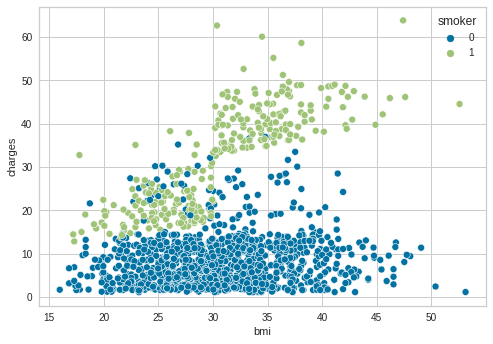

In [66]:
import seaborn as sns # Biblioteca que plota gráficos
sns.scatterplot(data=dados, x='bmi', y='charges',hue='smoker'); 
# No eixo X o IMC, eixo Y o valor do plano (/1000) e as cores diferenciam os fumantes dos não fumantes.

### Modelo de Regressão Linear

O primeiro modelo selecionado para este conjunto de dados e para a resposta que o cliente precisa (**quanto cobrar do cliente**) é o modelo de regressão linear.

In [72]:
from sklearn.linear_model import LinearRegression # Estou baixando a biblioteca do modelo de regressão linear para aplicar.

x = dados[['bmi', 'smoker','age']] # IMC, fumante e idade são as variáveis que utilizaremos para este modelo.
y = dados[['charges']]             # Variável alvo (Y): custo.

model_rli = LinearRegression()     # aqui está o modelo de regressão linear
model_rli.fit(x, y)                # modelo atuando em todos os dados (não foi separado em teste e treino ainda)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

O modelo está pronto, abaixo, pode testar com valores aleatórios para saber quanto cobrar de acordo com três informações do futuro cliente: IMC, Idade e se é fumante.

In [73]:
# Preencher cliente novo:

IMC = 33          # Indice de massa corpórea
Fumante = 1       # 1 - SIM 0 - NAO
Idade = 30        
cobrar = model_rli.predict([[IMC,Fumante,Idade]]) 
print('De acordo com o modelo, o valor anual a cobrar deste cliente é de US$ {:.2f}'.format(np.mean(cobrar*1000)))

De acordo com o modelo, o valor anual a cobrar deste cliente é de US$ 30579.58


### Métrica EQM para validação do modelo e Holdout

**Root Mean Squared Error (RMSE) ou Erro Quadrático Médio (EQM)** é uma excelente métrica para modelos de regressão, além de ser muito fácil de interpretar. A Raiz Quadrada do Erro Quadrático Médio — ou simplesmente RMSE em inglês — nada mais é que a diferença entre o valor que foi previsto pelo seu modelo e o valor real que foi observado.

Por exemplo, imagine que você está construindo um modelo para prever preço de casas. Esse modelo deveria ter previsto o valor de 100 mil para um exemplo no seu conjunto, mas ele previu 99 mil: esse -R$ 1 mil de diferença é o erro do seu modelo.

Agora é só repetir esse processo para todo seu conjunto de treino ou teste, elevar o erro ao quadrado, tirar a média de todos os valores do conjunto e, por fim, calcular a raiz quadrada.

fonte: (https://paulovasconcellos.com.br/)

**Método HOLDOUT:** consiste em dividir o conjunto total de dados em dois subconjuntos mutuamente exclusivos, um para treinamento (estimação dos parâmetros) e outro para teste (validação). O conjunto de dados pode ser separado em quantidades iguais ou não.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
#from sklearn.preprocessing import StandardScaler

# Separe os dados em teste e treinamento 
Xtreino, Xteste, ytreino, yteste = train_test_split(x, y, test_size = 0.25)

# Normalizando as variáveis X
#scaler = StandardScaler()
#Xtreino = scaler.fit_transform(Xtreino)
#Xteste = scaler.fit_transform(Xteste) 

# Ajuste do modelo nos dados de TREINO
regressao = LinearRegression()
regressao.fit(Xtreino, ytreino)

# Utilize o modelo ajustado para predizer os dados de TESTE
preditos = regressao.predict(Xteste) 

# Calcule o Erro Quadrático Médio nos dados de TESTE 
eqm = mean_squared_error(yteste, preditos)
print('EQM da Regressão Linear : {}'.format(round(eqm, 2)))

EQM da Regressão Linear : 31.54


Abaixo, repetições da técnica Holdout, de maneira a variar os dados que ficam no conjunto de treino e teste. Guardando os resultados do EQM para cada repetição e, no final, calculando a média para obter uma valor mais estável para o EQM.

In [77]:
# Média do valor mais estável para o EQM

R = 100   # Quantidade de vezes que vai rodar
eqms = []

x = dados[['bmi', 'smoker','age']]
y = dados['charges'] 

for i in range(R):
    Xtreino, Xteste, ytreino, yteste  = train_test_split(x, y, test_size = 0.25)
    #scaler = StandardScaler()
    #Xtreino = scaler.fit_transform(Xtreino)
    #Xteste = scaler.fit_transform(Xteste) 
    reg = LinearRegression()
    reg.fit(Xtreino, ytreino)
    preditos = reg.predict(Xteste)
    eqm = mean_squared_error(yteste, preditos)
    eqms.append(eqm)

print('Media dos EQM da Regressão Linear : {}'.format(round(np.mean(eqms),2)))

Media dos EQM da Regressão Linear : 37.47


Resultado final da saída dos teste:

In [89]:
comparativo = pd.DataFrame({'Atual': yteste, 'Preditos': preditos})*1000
comparativo.sample(4)

,Atual,Preditos
261,17085.2676,25629.935082
762,19040.8760,29107.117021
910,2639.0429,3168.398814
989,14571.8908,24622.037328


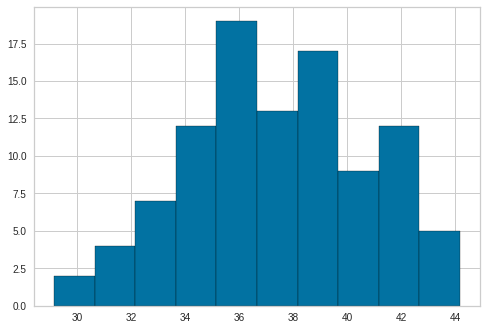

In [90]:
import matplotlib.pyplot as plt

plt.hist(eqms, edgecolor = 'black')
plt.show()

O coeficiente de determinação, também chamado de R², é uma medida de ajuste de um modelo estatístico linear generalizado, como a regressão linear simples ou múltipla, aos valores observados de uma variável aleatória. O R² varia entre 0 e 1, por vezes sendo expresso em termos percentuais.

In [88]:
from sklearn.metrics import r2_score
score = r2_score(yteste,preditos)
print('O modelo consegue explicar em {:.2f}% o resultado obtido.'.format(score*100))

O modelo consegue explicar em 74.76% o resultado obtido.


## Modelo K-NN (vizinhos mais próximos)

texto

In [84]:
dados.sample(3)

,age,bmi,charges,sex,smoker
1186,20,35.625,37.465344,0,1
474,54,25.100,25.382297,0,1
206,59,26.400,11.743299,0,0
